In [1]:
import pandas as pd
import numpy as np
from os.path import join, isfile

import matplotlib
import matplotlib.pyplot as plt

In [50]:
def load_labels(start, end, label_path, run_freq, file_format):
    labels = []
    for run_date in pd.date_range(start, end, freq=run_freq[0], closed="left"):
        file_name = join(label_path, f'model_labels_{run_date.strftime("%Y-%m-%d_%H%M")}.{file_format}')
        if isfile(file_name):
            if file_format == 'parquet': labels.append(pd.read_parquet(file_name))
            elif file_format == 'csv':   labels.append(pd.read_csv(file_name))
        else:
            continue

    return pd.concat(labels)

def load_objects(start, end, label_path, run_freq, file_format):
    labels = []
    for run_date in pd.date_range(start, end, freq=run_freq[0], closed="left"):
        file_name = join(label_path, f'track_step_NCARSTORM_d01_{run_date.strftime("%Y%m%d-0000")}.{file_format}')
        
        if isfile(file_name):
            if file_format == 'parquet': labels.append(pd.read_parquet(file_name))
            elif file_format == 'csv':   labels.append(pd.read_csv(file_name))
        else:
            continue

    return pd.concat(labels)

In [185]:
# this file has all the CNN, GMM, DNN predictions for 2017-2019 storms
labels = load_labels("2017-01-01", "2019-12-31", "/glade/work/cbecker/NCAR700_objects/output_object_based/labels/", "daily", "csv") # all storms in WRF dataset
objects = load_objects("2017-01-01", "2019-12-31", "/glade/work/cbecker/NCAR700_objects/track_data_hrrr_3km_csv_refl", "daily", "csv") # all storms in WRF dataset

# create unique id for both datasets (if needed)
labels['unique_id'] = labels['Run_Date'].astype(str).apply(lambda x: x[:10]) + '.' + labels['Track_ID'].apply(lambda x: str(x[-3:]).lstrip("0")) + '.' + labels['Duration'].astype(str)
objects['unique_id'] = objects['Run_Date'].astype(str).apply(lambda x: x[:10]) + '.' + objects['Track_ID'].apply(lambda x: str(x[-3:]).lstrip("0")) + '.' + objects['Duration'].astype(str)

# this file has hand labels for training/testing dataset storms (and CNN predictions)
#cnn_training_data = pd.read_csv('/glade/work/sobash/HWT_mode/model_cnn_test2_addstorms2_noaugval_newtrain/predictions_train.csv') # all storms in hand labeled dataset
#cnn_test_data     = pd.read_csv('/glade/work/sobash/HWT_mode/model_cnn_test2_addstorms2_noaugval_newtrain/predictions_test.csv')

#cnn_training_data = cnn_training_data.iloc[:1781] #only get first set of storms (rest are rotated)
#hand_labeled = pd.concat([cnn_training_data, cnn_test_data])

# create matched storms dataframe
#matched_labels = labels[labels['unique_id'].isin(hand_labeled.loc[:, 'unique_id'])] #extract only the storms with hand labels

# prevent probs larger than 1
prob_cols = [col for col in labels.columns if 'prob' in col]
labels.loc[:, prob_cols] = np.where(labels[prob_cols] > 0.999, 0.999, labels[prob_cols])

# read LR predictions
lr_predictions = pd.read_pickle('lr_predictions_2017-2019_storms.pk')
lr_prob_values = lr_predictions[['LR_QLCS_prob', 'LR_Supercell_prob', 'LR_Disorganized_prob']].values
lr_prob_argmax = np.argmax(lr_prob_values, axis=1)

modes = ['QLCS', 'Supercell', 'Disorganized']
for mode in modes: labels[f'LR_{mode}_prob'] = lr_predictions[f'LR_{mode}_prob'].values
labels['LR_label'] = [ modes[n] for n in np.argmax(lr_prob_values, axis=1) ]
labels['LR_label_prob'] = lr_prob_values[range(lr_prob_argmax.size), lr_prob_argmax]

109082


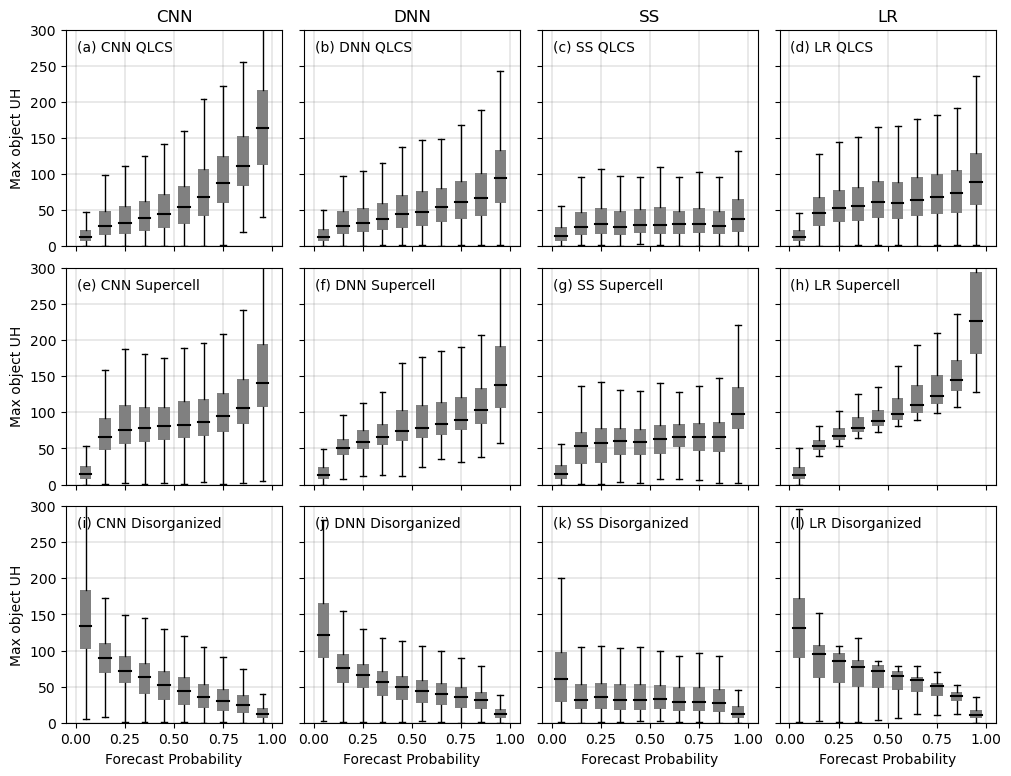

In [186]:
fig, axes = plt.subplots(3, 4, sharex='col', sharey='row', figsize=(12,9))
plt.subplots_adjust(hspace=0.1,wspace=0.1)

panels = [['a', 'b', 'c', 'd'], ['e', 'f', 'g', 'h'], ['i', 'j', 'k', 'l']]
# loop through each panel
for n,model in enumerate(['CNN_1', 'DNN_1', 'SS', 'LR']):
    for k,mode in enumerate(['QLCS', 'Supercell', 'Disorganized']):
        ax1 = axes[k,n]
 
        # adjust axes labels/ticks/etc
        ax1.set_xlim((-0.05,1.05))
        #ax1.set_xticks(np.arange(0,1.01,0.1))
        ax1.set_ylim((0,300))
        ax1.grid(linewidth=0.25, color='gray')
        if k==2: ax1.set_xlabel('Forecast Probability')
        if n==0: ax1.set_ylabel('Max object UH')
        if k==0: ax1.set_title(model.replace('_1', ''))

        #ax1.scatter(matched_labels["%s_Supercell_prob"%model], matched_labels['UP_HELI_MAX_max'], s=20, c='k', alpha=1)
        
        ax1.text(0.05,0.9,'(%s) %s %s'%(panels[k][n], model.replace('_1', ''), mode), transform=ax1.transAxes)
        
        boxplot_data = []
        for p in np.arange(0,1.01,0.1):
            mask = (labels["%s_%s_prob"%(model,mode)] >= p) & (labels["%s_%s_prob"%(model,mode)] < p+0.1)
            these_data = objects['UP_HELI_MAX_max'][mask]
            boxplot_data.append( these_data )
            
        flierprops = dict(marker='o', markerfacecolor='0.6', markersize=0, markeredgecolor='0.6')
        medianprops = dict(color='k', linewidth=1.5)
        boxprops = dict(linestyle='-', linewidth=0, facecolor='gray')

        ax1.boxplot(boxplot_data, positions=np.arange(0,1.01,0.1)+0.05, widths=0.06, manage_ticks=False, patch_artist=True, \
                    boxprops=boxprops, medianprops=medianprops, flierprops=flierprops)
        
        
        #ax1.violinplot(boxplot_data, positions=np.arange(0,1.01,0.1)+0.05, widths=0.06)

Text(0.5, 1.0, '(c) Disorganized')

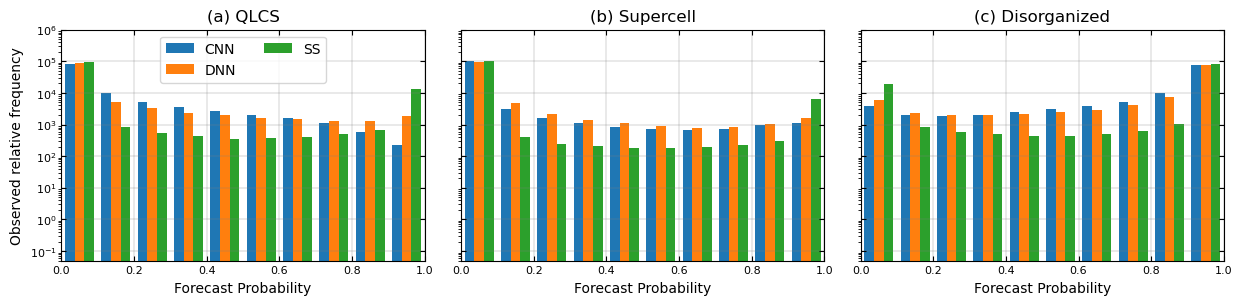

In [187]:
fig, axes = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,3))
fig.subplots_adjust(hspace=0.25, wspace=0.1)
axes = axes.flatten()

for n,mode in enumerate(['QLCS', 'Supercell', 'Disorganized']):
    ax = axes[n]
    n, bins, patches = ax.hist( [ labels[f'CNN_1_{mode}_prob'], labels[f'DNN_1_{mode}_prob'], labels[f'SS_{mode}_prob'] ],
                                     bins=np.arange(0,1.01,0.1), log=True, label=['CNN', 'DNN', 'SS'])
        
    ax.grid(linewidth=0.25, color='gray')
    ax.set_ylim((0.5e-1,1e6))
    ax.set_xlim((0,1))
    ax.tick_params(top=True, right=True, direction='in', labelsize=8)
        
axes[0].legend(ncol=2,loc='upper center')

axes[0].set_ylabel('Observed relative frequency')
#axes[2].set_ylabel('Observed relative frequency')
axes[0].set_xlabel('Forecast Probability')
axes[1].set_xlabel('Forecast Probability')
axes[2].set_xlabel('Forecast Probability')
axes[0].set_title('(a) QLCS')
axes[1].set_title('(b) Supercell')
axes[2].set_title('(c) Disorganized')
#axes[3].set_title('(d) CNN/DNN avg')

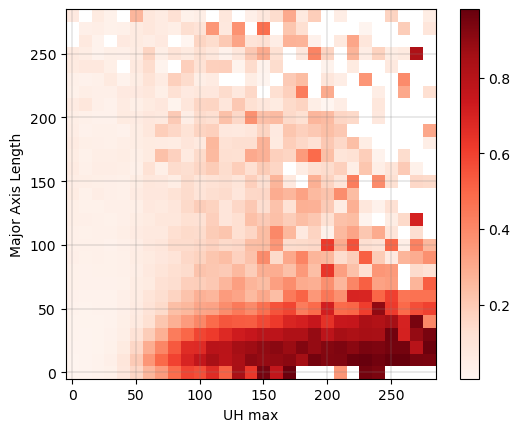

In [196]:
from scipy.stats import binned_statistic_2d, mode
x_bins = np.arange(0,300,10)
y_bins = np.arange(0,300,10)

# create columns with int and names
#categories = { 'QLCS': 0, 'Supercell': 1, 'Disorganized': 2 }
#labels['CNN_1_label_int'] = labels['CNN_1_label'].apply(lambda x: categories[x])

ret = binned_statistic_2d(objects['UP_HELI_MAX_max'], objects['major_axis_length'], labels['CNN_1_Supercell_prob'], statistic=np.mean, bins=[x_bins, y_bins])
#mask = labels['CNN_1_Supercell_prob'] < 0.25
#plt.scatter(objects['UP_HELI_MAX_max'][mask], objects['major_axis_length'][mask], c=labels['CNN_1_Supercell_prob'][mask], s=5)
plt.imshow(ret.statistic.T, origin='lower',cmap=plt.get_cmap('Reds'))

plt.xlabel('UH max')
plt.ylabel('Major Axis Length')
plt.xticks(ticks=range(0,30,5), labels=x_bins[range(0,30,5)])
plt.yticks(ticks=range(0,30,5), labels=y_bins[range(0,30,5)])
plt.grid(linewidth=0.25, color='gray')
plt.colorbar()